# Project 7 - Create a model to predict the revenues of potential customers using ANOVA and Linear Regression.

🎯 Goal: Create a model to predict the future revenue of children based on their location, the revenue of their parents and the gini index; in order to target future customers.

## Part 1 - Data Exploration

<i> Data collection is the process of gathering and measuring information on targeted variables in an established system, which then enables one to answer relevant questions and evaluate outcomes.[Wikipedia] </i>

Here is what we need to perform the modeling:
  
  - World Income Distribution: This database is mainly composed of studies carried out at the national level for a good number of countries, and contains the income distributions of the populations concerned. 
  - Gini Index from the World Bank: https://data.worldbank.org/indicator/SI.POV.GINI 
  - Number of inhabitants of each country present in the data.
 
 

🎯 Goal of Step 1: Collect, Summarize and Discuss the relevance of the Data Collected for the Modeling.

- Year(s) selected
- Countries selected
- World Population coverage by selection
- Description of data from World Income Distribution: 
    - Type of quantile? 
    - Discuss the sampling method. 
    - Unit ($PPP): Why this unit is relevant?

<i> N.B: We will call each quantile an income class here. Thus, the value of the income column for a given quantile can be seen as the average income of people belonging to the income class corresponding to that quantile. </i>

### Get started

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import seaborn as sns
import missingno as msno 
from collections import Counter
import scipy.stats as st

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [9]:
# Read the data from the World Income Distribution 
inc = pd.read_csv(Path.cwd()/'Raw'/'data-projet7.csv',decimal=",")
inc.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [10]:
# Read data from The World Bank
gpop = pd.read_csv(Path.cwd()/'Raw'/'gini_pop.csv',na_values = ['..' , 0])

# What information do we have here?
gpop['Series Name'].unique()

array(['Gini index (World Bank estimate)', 'Population, total', nan,
       'Data from database: World Development Indicators',
       'Last Updated: 02/17/2021'], dtype=object)

### What is the timeframe available?

In [11]:
# World Income Distribution Dataset
inc['year_survey'].describe()

count    11599.000000
mean      2007.982757
std          0.909633
min       2004.000000
25%       2008.000000
50%       2008.000000
75%       2008.000000
max       2011.000000
Name: year_survey, dtype: float64

In [12]:
tmp = inc.groupby('year_survey').count().reset_index()[['year_survey','country']]

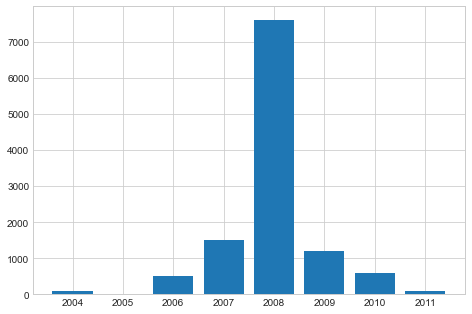

In [13]:
# Visualize the data per year
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = tmp['year_survey'].to_list()
y = tmp['country'].to_list()
ax.bar(x,y)
plt.savefig(Path.cwd()/'Plot'/'M1_year_dataset.png')
plt.show()

<b> We have data from 2004 and 2011, which is relatively old. In real-life, we will search for more recent data. Let's say the last 3 to 5 years to be more representative.</b>

Potential more recent data available here: https://www.wider.unu.edu/database/world-income-inequality-database-wiid34

### What is the coverage in terms of country?

In [14]:
# Countries in the selection
inc['country'].nunique()

116

<b> The selection includes 116 countries of the World, on 194 independent countries and 249 total countries (ISO 'Country codes' standard). </b>
<i> https://en.wikipedia.org/wiki/ISO_3166-1 </i> 

- What are the countries not included into our analysis?

In [15]:
# List of all countries in the World
co = pd.read_csv(Path.cwd()/'Raw'/'countries.csv')

# Check the number
co['id'].nunique()

249

Source: https://stefangabos.github.io/world_countries/

In [16]:
# Merge with our selection to extract the countries not included
co['alpha3'] = co['alpha3'].str.upper() # uppercase the column
df = pd.merge(inc,co[['alpha3','name']], left_on = 'country', right_on = 'alpha3', how = 'right') # keep all countries of the World

excl = df[df['country'].isna() == True] # select the countries not included in the World Income Distribution
list_ex = excl['name'].to_list() # create a list
list_ex

['Afghanistan',
 'Åland Islands',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Aruba',
 'Australia',
 'Bahamas',
 'Bahrain',
 'Barbados',
 'Belize',
 'Benin',
 'Bermuda',
 'Bonaire, Sint Eustatius and Saba',
 'Botswana',
 'Bouvet Island',
 'British Indian Ocean Territory',
 'Brunei Darussalam',
 'Burundi',
 'Cabo Verde',
 'Cayman Islands',
 'Chad',
 'Christmas Island',
 'Cocos (Keeling) Islands',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Cuba',
 'Curaçao',
 'Djibouti',
 'Dominica',
 'Equatorial Guinea',
 'Eritrea',
 'Ethiopia',
 'Falkland Islands (Malvinas)',
 'Faroe Islands',
 'French Guiana',
 'French Polynesia',
 'French Southern Territories',
 'Gabon',
 'Gambia',
 'Gibraltar',
 'Greenland',
 'Grenada',
 'Guadeloupe',
 'Guam',
 'Guernsey',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Heard Island and McDonald Islands',
 'Holy See',
 'Hong Kong',
 'Isle of Man',
 'Jamaica',
 'Jersey',
 'Kiribati',
 "Korea (Democratic People's 

In [17]:
len(list_ex)

134

<b> 134 countries are not included in our dataset of the World Income Distribution. Are these countries important and relevant for the analysis? </b>

In the list of countries not included into our analysis, we found 3 categories of countries:

<b> 1) Non-self governing territories, e.g:</b> <i> 'Virgin Islands (U.S.)','Turks and Caicos Islands','Sint Maarten (Dutch part)',...</i>
This group does not really matter for the analytics as they represent a very few proportion of the world population and because they are a part of a bigger country or sovereign territory included in our dataset. 

<b>2) Independent Countries with high income suspected, e.g:</b> <i>'Switzerland','Singapore','Qatar','Saudi Arabia','United Arab Emirates','New Zealand',"Korea (Democratic People's Republic of)",'Kuwait','Hong Kong','Australia',...</i>
From a Market Growth perspective, this group is interesting to consider as they hold high potential revenue customers. However, for revenues predictions, they might behave as outliers - pulling out the distribution towards the higher values.

<b>3) Independent Countries with low income suspected, e.g:</b> <i>'Afghanistan','Zambia', 'Zimbabwe', 'Uzbekistan','Tunisia', 'Turkmenistan','Suriname','South Sudan','Somalia', 'Senegal','Rwanda',...</i>
From a Market Growth perspective, this group could be excluded from the analytics as they most likely represents low potential countries. 
Similarly than the group 2, for modeling revenues across the World, we could also expect them to behave as outliers - pulling out the data towards the low values this time.


### What is the coverage in terms of World population?

In [18]:
# Get information about the population
pop = gpop[gpop['Series Name'] == 'Population, total'].iloc[:,2:]

 # Convert into numeric values
pop.iloc[:,2:] = pop.iloc[:,2:].apply(pd.to_numeric, errors='coerce')

# We have the world population in the last row
world = pop.tail(1)
world

,Country Name,Country Code,2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011]
527,World,WLD,6.431552e+09,6.511748e+09,6.592735e+09,6.674204e+09,6.756918e+09,6.839574e+09,6.921872e+09,7.002860e+09


In [19]:
# Calculate the total population based on the countries selected
list_country = inc['country'].to_list() 
pop = pop[pop['Country Code'].isin(list_country)]

# Get the Total per year
pop.loc['Total',2:] = pop.sum(axis=0) 
pop.fillna('Total',inplace=True)
pop.tail(1)

<ipython-input-19-f11401072b0a>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  pop.loc['Total',2:] = pop.sum(axis=0)


,Country Name,Country Code,2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011]
Total,Total,Total,5.901527e+09,5.970761e+09,6.040405e+09,6.110310e+09,6.180742e+09,6.250889e+09,6.320158e+09,6.387880e+09


In [20]:
# Concatenate data together
pop2 = pop.tail(1).append(world)
pop2 = pop2.iloc[:,2:].apply(pd.to_numeric)
pop2

,2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011]
Total,5.901527e+09,5.970761e+09,6.040405e+09,6.110310e+09,6.180742e+09,6.250889e+09,6.320158e+09,6.387880e+09
527,6.431552e+09,6.511748e+09,6.592735e+09,6.674204e+09,6.756918e+09,6.839574e+09,6.921872e+09,7.002860e+09


In [21]:
# Calculate coverage of World population with our selection
pop2.loc['pct'] = pop2.iloc[0,:]*100/ pop2.iloc[1,:]
pop2

,2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011]
Total,5.901527e+09,5.970761e+09,6.040405e+09,6.110310e+09,6.180742e+09,6.250889e+09,6.320158e+09,6.387880e+09
527,6.431552e+09,6.511748e+09,6.592735e+09,6.674204e+09,6.756918e+09,6.839574e+09,6.921872e+09,7.002860e+09
pct,9.175899e+01,9.169213e+01,9.162214e+01,9.155115e+01,9.147281e+01,9.139295e+01,9.130706e+01,9.121816e+01


<b> With our selection of countries, we covered 91% of the World population which is a relatively good coverage to be representative. </b>

<b> N.B: The data for the gini index have been extracted for the same list of country. </b>

## Part 2 - Inequalities of Revenues in the World

#### Distribution of Incomes

<b> In this section, we want to show the diversity in terms of income distribution among the countries in the World. </b>

<i> For that purpose, we will select 5 countries slightly different and showcase the distribution of their respective incomes, Lorenz curve and Gini Index.</i>

In [22]:
# Our current dataset
df2 = df[df['country'].isna() == False].drop(['country','alpha3'],axis=1)
df2.head()

,year_survey,quantile,nb_quantiles,income,gdpppp,name
2,2008.0,1.0,100.0,728.89795,7297.0,Albania
3,2008.0,2.0,100.0,916.66235,7297.0,Albania
4,2008.0,3.0,100.0,1010.91600,7297.0,Albania
5,2008.0,4.0,100.0,1086.90780,7297.0,Albania
6,2008.0,5.0,100.0,1132.69970,7297.0,Albania


In [23]:
# Here is the list of countries for which we have gini index data without NaN values
tp = gpop[(gpop['Series Name'] == 'Gini index (World Bank estimate)')].iloc[:,2:].dropna()['Country Name'].to_list()

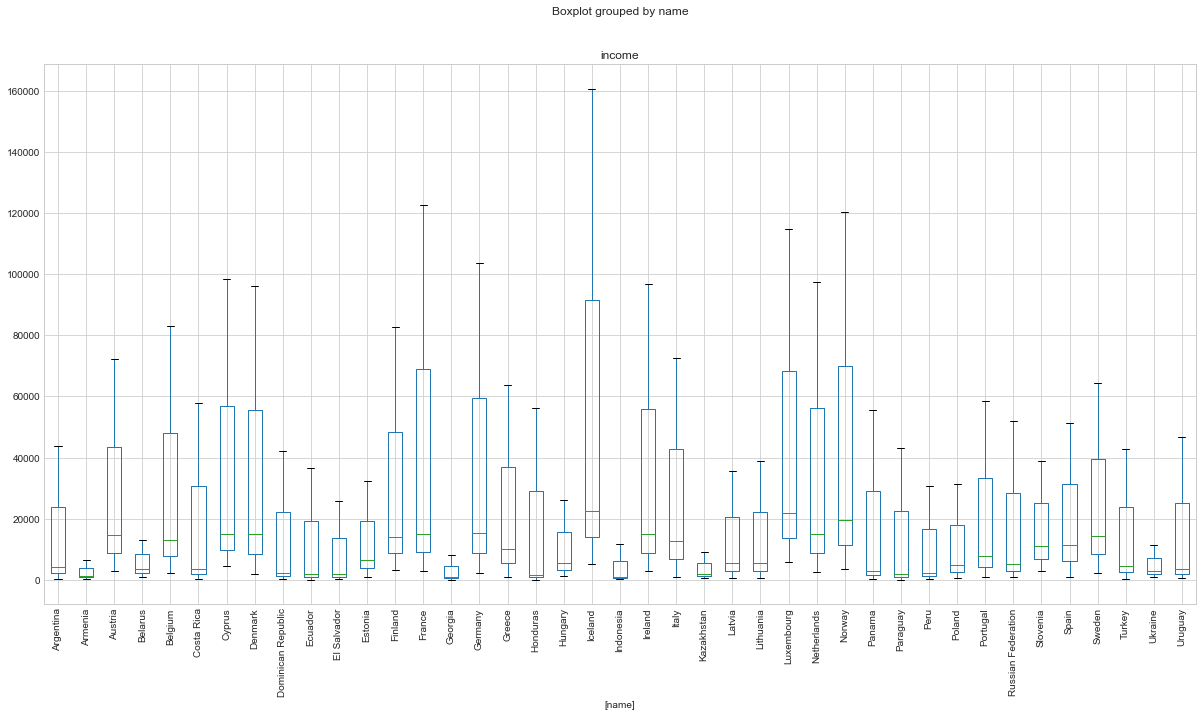

In [24]:
# We are gonna use the min, max and median to help to select countries with very different income
tmp = df2[df2['name'].isin(tp)]
tmp = df2[(df2['name'].isin(tp)) & ((df2['quantile'] == 1) | (df2['quantile'] == 50) | (df2['quantile'] == 100))][['name','income']] 

# Create boxplots to visualize the income by countries
tmp.boxplot(by='name',figsize=(20,10))
plt.xticks(rotation=90)
plt.savefig(Path.cwd()/'Plot'/'BoxPlot_Income_Countries.png')
plt.show()

Based on this visualization, we decide to select the following countries to represent the broad diversity of income across the World:
- Iceland
- Denmark
- Argentina
- Georgia
- El Salvador

In [25]:
# Select countries
selection = ['Iceland','Denmark','Georgia','Argentina','El Salvador']
df3 = df2.copy()
df3 = df3[df3.name.isin(selection)]

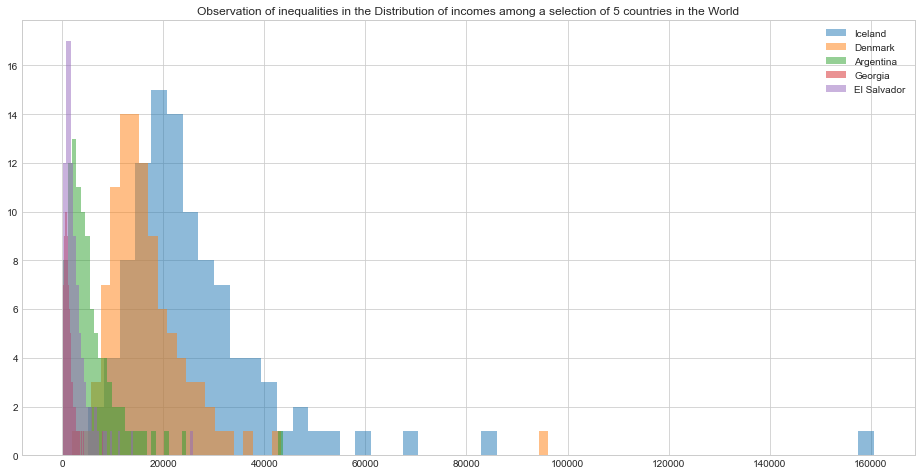

In [26]:
# Overlapped the distribution to compare countries together
plt.figure(figsize=(16,8))
plt.hist(df3['income'].where(df3.name == 'Iceland'), bins=50, alpha=0.5, label='Iceland')
plt.hist(df3['income'].where(df3.name == 'Denmark'), bins=50, alpha=0.5, label='Denmark')
plt.hist(df3['income'].where(df3.name == 'Argentina'), bins=50, alpha=0.5, label='Argentina')
plt.hist(df3['income'].where(df3.name == 'Georgia'), bins=50, alpha=0.5, label='Georgia')
plt.hist(df3['income'].where(df3.name == 'El Salvador'), bins=50, alpha=0.5, label='El Salvador')
plt.title('Observation of inequalities in the Distribution of incomes among a selection of 5 countries in the World')
plt.legend(loc='upper right')
plt.savefig(Path.cwd()/'Plot'/'Histogram_Income_CountriesSelected.png')
plt.show()

We can see clearly that each distribution is highly skew to the right (high values of incomes). Reflecting that among each countries there are some important inequalities of revenues. Also we can notice that Iceland and Denmark are globally richer than the rest of the countries selected: their distribution is shifted to the right. 

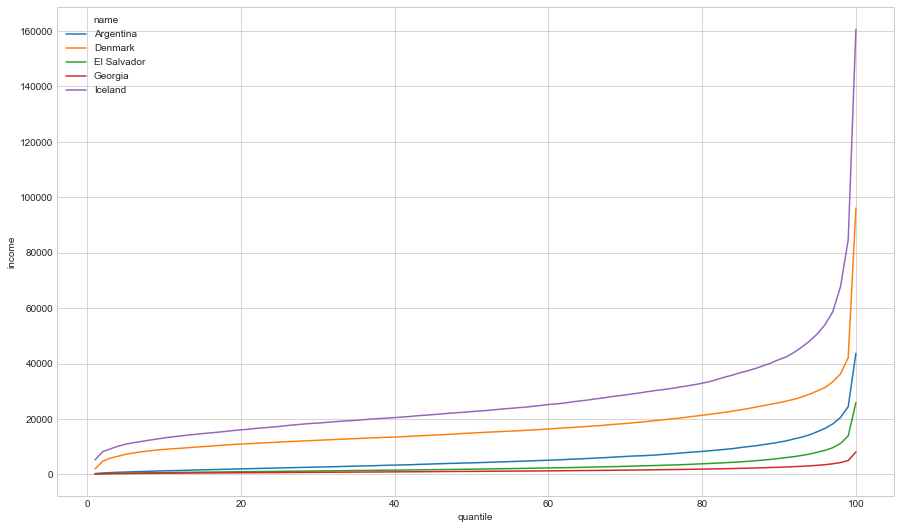

In [27]:
# Plot the income value by quantile for the countries selected without transformation
plt.figure(figsize=(15,9))
sns.lineplot(x = df3['quantile'],y = df3['income'], hue = df3['name'])
plt.savefig(Path.cwd()/'Plot'/'LinePlot_IncomebyQuantiles_CountriesSelected_beforeLog.png')
plt.show()

Here, we can see that the incomes distribution across the quantiles are following an exponential distribution because of the strong tails.


<i> The log transformation is, arguably, the most popular among the different types of transformations used to transform skewed data to approximately conform to normality. Another popular use of the log transformation is to reduce the variability of data, especially in data sets that include outlying observations. This can be valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics. </i>

Source: Online Statistics Education: An Interactive Multimedia Course of Study https://onlinestatbook.com/2/transformations/log.html


In [28]:
# Apply a log-transformation on the income 
df3['log_income'] = np.log(df3['income'])

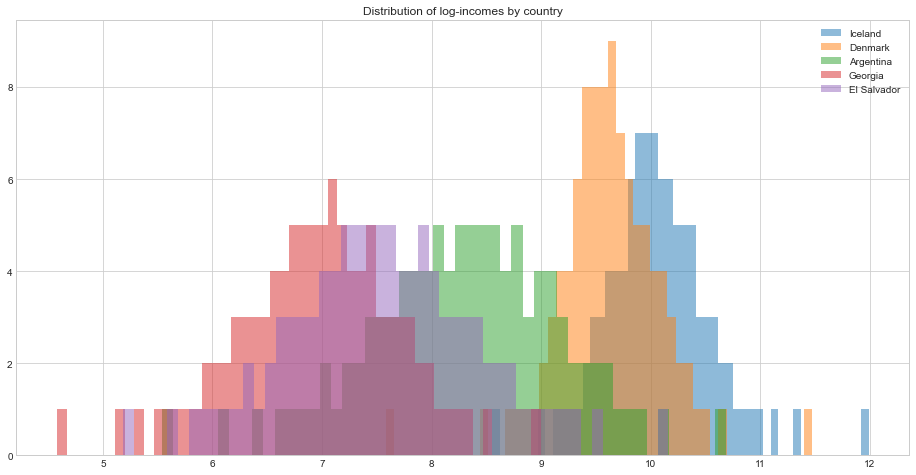

In [29]:
# Overlapped the distribution to compare countries together
plt.figure(figsize=(16,8))
plt.hist(df3['log_income'].where(df3.name == 'Iceland'), bins=50, alpha=0.5, label='Iceland')
plt.hist(df3['log_income'].where(df3.name == 'Denmark'), bins=50, alpha=0.5, label='Denmark')
plt.hist(df3['log_income'].where(df3.name == 'Argentina'), bins=50, alpha=0.5, label='Argentina')
plt.hist(df3['log_income'].where(df3.name == 'Georgia'), bins=50, alpha=0.5, label='Georgia')
plt.hist(df3['log_income'].where(df3.name == 'El Salvador'), bins=50, alpha=0.5, label='El Salvador')
plt.title('Distribution of log-incomes by country')
plt.legend(loc='upper right')
plt.savefig(Path.cwd()/'Plot'/'Histogram_LogIncome_CountriesSelected.png')
plt.show()

The benefit of the transformation is clear on the distribution of incomes by country. Now we can distinguish some global pattern:

- Georgia is the poorest country of the selection
- Argentina & Turkey seem to be in the middle range of the selection. 
- Denmark and Iceland are the richest countries of the selection.

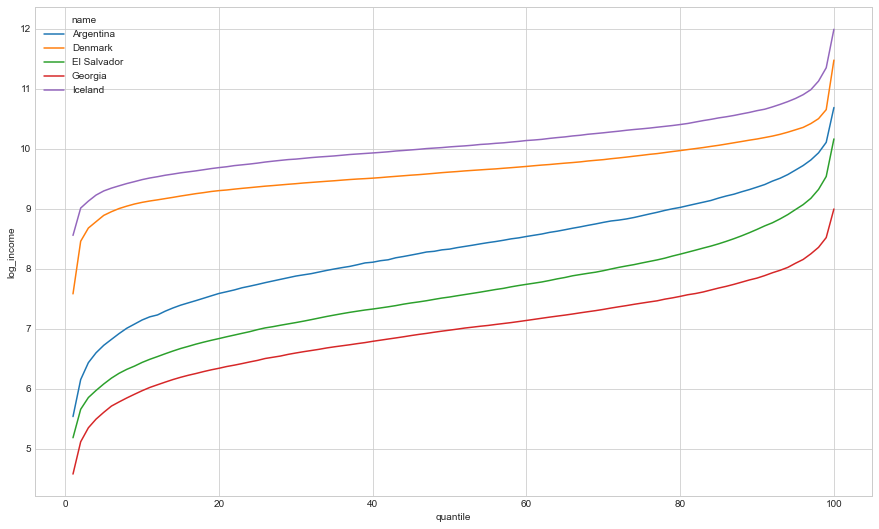

In [30]:
# Plot the income value by quantile for the countries selected after transformation
plt.figure(figsize=(15,9))
sns.lineplot(x = df3['quantile'],y = df3['log_income'], hue = df3['name'])
plt.savefig(Path.cwd()/'Plot'/'LinePlot_LogIncomebyQuantiles_CountriesSelected.png')
plt.show()

We can observe the same on this plot: Denmark and Iceland are close in terms of distribution of income, so do Turkey and Argentina, and Georgia is the country with the lowest average income among this selection.

#### Lorenz Curve

The Lorenz concentration curve is a way to represent the distribution function of a variable X. It is used in particular in economics to measure inequalities in the possession of wealth. <b> We will use it here to assess inequalities in terms of the distribution of incomes among the group of countries selected. </b>

In [31]:
def lorenz_curve(X):
    lorenz = np.cumsum(np.sort(X['income'])) / X['income'].sum()
    lorenz = np.append([0],lorenz) 
    
    #Plot Lorenz curve
    fig, ax = plt.subplots(figsize=[7,5])
    plt.plot([0,1], [0,1], color='k')
    plt.plot(np.arange(lorenz.size)/(lorenz.size-1), lorenz,drawstyle='steps-post',color='indianred')
    plt.title(X.name)
    plt.savefig(Path.cwd()/'Plot'/'LorenzCurve_selectedCountries.png')
    plt.show()

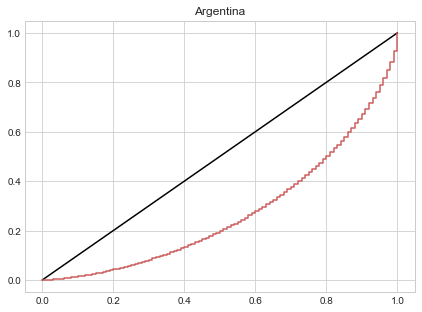

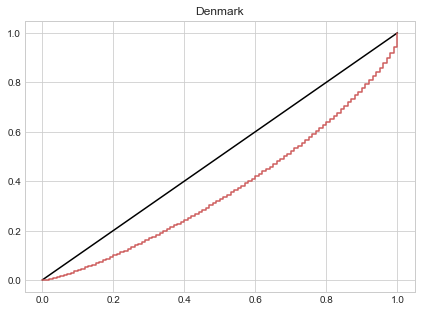

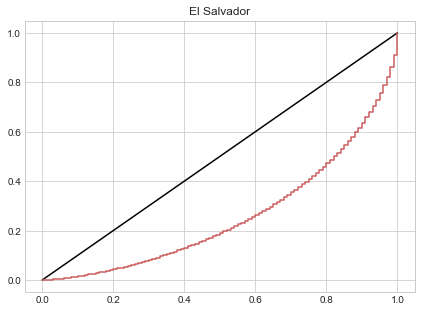

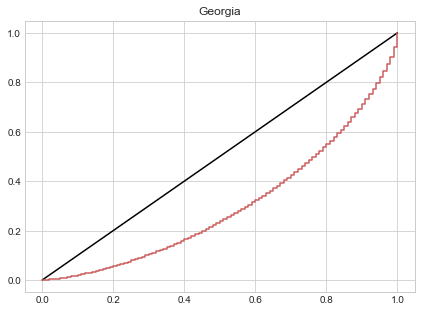

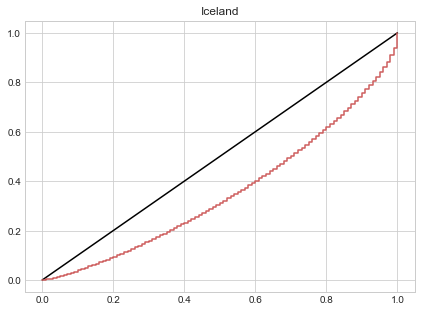

""


In [32]:
# Plot Lorenz Curves for each country selected
df3[['name','income']].groupby('name').apply(lorenz_curve)

<b> We can see here that there are more inequalities in Turkey, Argentina and Georgia than in Iceland and Denmark, as we could have expected. </b>

<i> The Lorenz curve is further away from the first bisector line. </i> 

#### Gini Index

The Gini index represents the area between the Lorenz curve and the first bisector line. It is a good metric to summarize the information from the Lorenz curve. In this section, we will visualize the evolution of the Gini Index over the years for the 5 countries selected.

In [33]:
# Get the data
gin = gpop[(gpop['Series Name'] == 'Gini index (World Bank estimate)')& (gpop['Country Name'].isin(selection))].iloc[:,
                                                                                                    2:].drop('Country Code',axis= 1)
gin.head()

,Country Name,2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011]
7,Argentina,48.6,48.0,46.7,46.6,45.3,44.1,44.5,42.7
53,Denmark,24.9,25.2,25.9,26.2,25.2,26.7,27.2,27.3
59,El Salvador,47.8,48.5,45.7,45.2,46.9,45.8,43.5,42.3
72,Georgia,36.2,37.4,36.9,38.1,38.5,38.2,39.5,39.6
88,Iceland,28.0,29.0,30.2,29.5,31.8,28.7,26.2,26.8


In [34]:
# Average Gini index
gin.mean(axis=1)

7     45.8125
53    26.0750
59    45.7125
72    38.0500
88    28.7750
dtype: float64

In [35]:
# For the records, the 5 countries have been selected not only because of their characteristics but alos because their data were complete.
gin.isna().sum()

Country Name     0
2004 [YR2004]    0
2005 [YR2005]    0
2006 [YR2006]    0
2007 [YR2007]    0
2008 [YR2008]    0
2009 [YR2009]    0
2010 [YR2010]    0
2011 [YR2011]    0
dtype: int64

In [36]:
# Unpivot the data
tmp = pd.melt(gin, id_vars=['Country Name'], var_name='year', value_name='value')

# Get rid of the weird names for years
tmp[['year','stuff']] = tmp['year'].str.split('[',expand=True)
tmp = tmp.drop('stuff',axis=1)
tmp.head()

,Country Name,year,value
0,Argentina,2004,48.6
1,Denmark,2004,24.9
2,El Salvador,2004,47.8
3,Georgia,2004,36.2
4,Iceland,2004,28.0


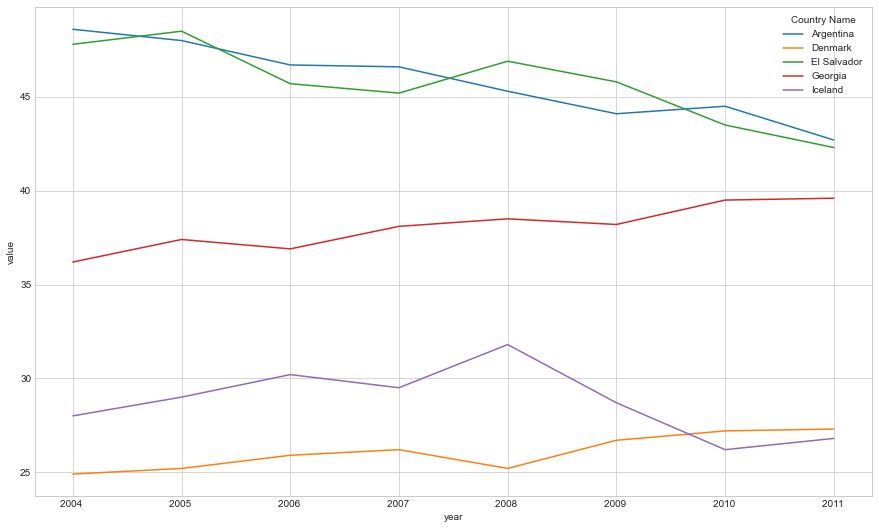

In [37]:
# Plot the Gini index over the years for the countries selected
plt.figure(figsize=(15,9))
sns.lineplot(x = tmp['year'],y = tmp['value'], hue = tmp['Country Name'])
plt.savefig(Path.cwd()/'Plot'/'GiniIndex_SelectedCountries.png')
plt.show()

The smallest the Gini Index The least inequalities in the Country. Here we see:
-  Denmark and Iceland are the countries with the least inequalities among the selection of countries. In 2011, they tend to have more or less the same index. The Index increase slightly in Denmark between 2008 and 2011 and while it decreased strongly in Iceland.
- Georgia and Turkey have in 2011 an index about 1.5 time bigger than the index of Denmark and Iceland. The index stayed relatively stable since 2007.
- Argentina is the country with the biggest inequalities in terms of income among its population. Its index is the highest of the selection. However, we can see that it tends to decrease since 2004 and is almost at the same level of Georgia and Turkey in 2011.

<b> We are now looking at all the countries in the World and ranking them by gini index ascending so from the country with the less inequality of incomes to the country with the biggest inequalities </b>

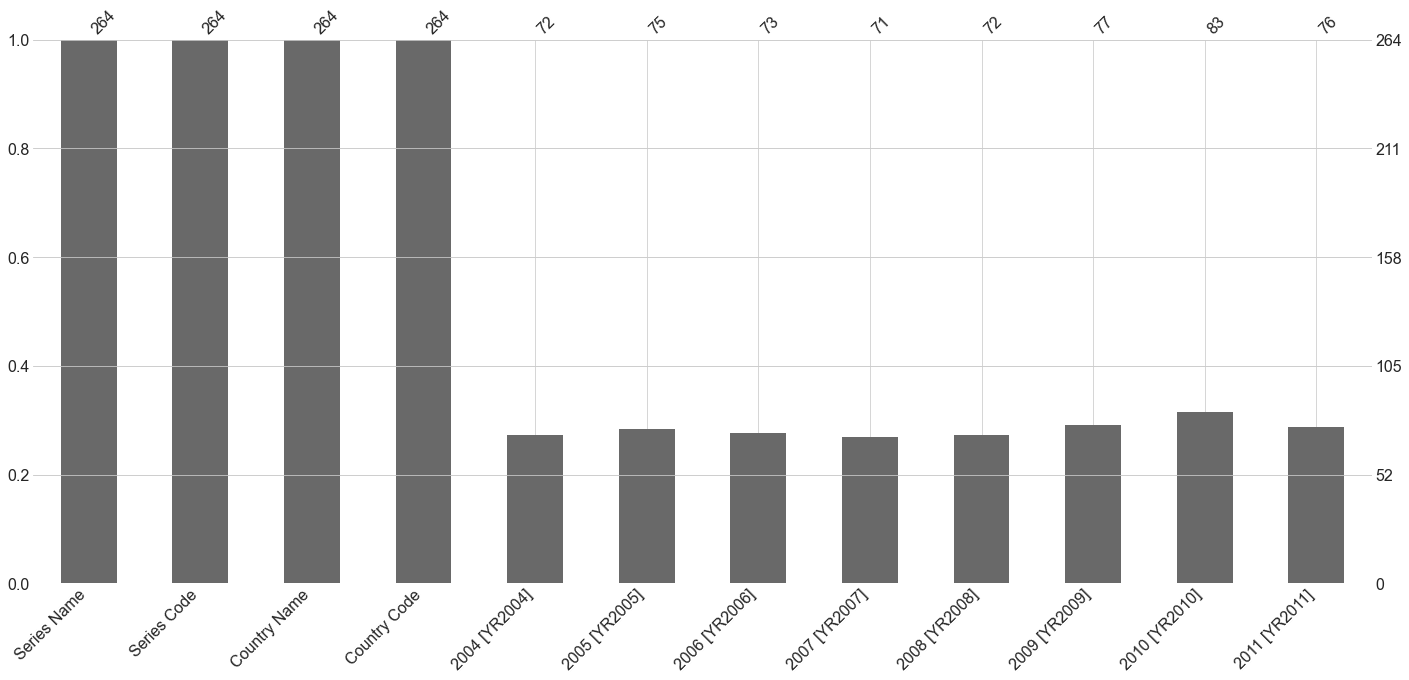

In [38]:
# Get the data for all countries in the World in 2011 with data
gin2 = gpop[(gpop['Series Name'] == 'Gini index (World Bank estimate)')]

#Check out the missing values 
msno.bar(gin2)
plt.show()

We have a lot of missing values in our dataset holding the gini index. For further analytics, it will be better to complete the data to increase the representativity and relevance of our observations. For that reason, we are re-calculating the gini index for all countries and all years with the data available.

In [39]:
def gini_index(X):
    # First we need to build the Lorenz curve
    lorenz = np.cumsum(np.sort(X['income'])) / X['income'].sum()
    lorenz = np.append([0],lorenz) 
    # Calculate the area under the curve
    AUC = lorenz[:-1].sum()/len(lorenz) 
    # Area btw the 1st bisector and the lorenz curve
    S = 0.5 - AUC 
    gini = 2*S
    return gini*100

In [33]:
# Get gini index
new_gini = df2[['name','income','year_survey']].groupby(['name','year_survey']).apply(gini_index).reset_index()
new_gini.rename(columns={0: "new_gini"},inplace=True)
new_gini.head()

,name,year_survey,new_gini
0,Albania,2008.0,32.141019
1,Argentina,2008.0,46.524916
2,Armenia,2008.0,28.030458
3,Austria,2008.0,29.532585
4,Azerbaijan,2008.0,32.903087


In [34]:
# Check our calculation with the gini indexes we already got for validation
tmp= pd.melt(gin2.drop(['Series Name','Series Code', 'Country Code'],axis=1), id_vars=['Country Name'], var_name='year', value_name='value')

# Get rid of the weird names for years
tmp[['year','stuff']] = tmp['year'].str.split('[',expand=True)
tmp = tmp.drop('stuff',axis=1)
tmp.head()

tmp['Country Name'] = tmp['Country Name'].astype('str')
tmp['year'] = tmp['year'].astype(int)

In [35]:
# Merge with our values
tmp = pd.merge(new_gini,tmp, left_on= ['name','year_survey'],right_on=['Country Name','year'],how='left')
tmp['diff'] = tmp['value']-tmp['new_gini']
tmp.head()

,name,year_survey,new_gini,Country Name,year,value,diff
0,Albania,2008.0,32.141019,Albania,2008.0,30.0,-2.141019
1,Argentina,2008.0,46.524916,Argentina,2008.0,45.3,-1.224916
2,Armenia,2008.0,28.030458,Armenia,2008.0,29.2,1.169542
3,Austria,2008.0,29.532585,Austria,2008.0,30.4,0.867415
4,Azerbaijan,2008.0,32.903087,Azerbaijan,2008.0,NaN,NaN


In [36]:
# How accurate is our own calculation compare to the estimated data provided by the World Bank
tmp['diff'].mean()

-1.7402574469621743

<b> In average, we notice a difference of about 1,74% between the estimated value provided by the World Bank and our calculation. This is relatively low, so we will consider our calculation as good and move on further with these values instead of the values from the World Bank. </b>

In [37]:
new_gini.groupby('year_survey').count()[['new_gini']]

,new_gini
year_survey,
2004.0,1
2006.0,5
2007.0,15
2008.0,75
2009.0,12
2010.0,6
2011.0,1


In [38]:
tmp.groupby('year').count()[['value']]

,value
year,
2004.0,1
2006.0,2
2007.0,8
2008.0,52
2009.0,9
2010.0,4
2011.0,0


We can see that we have increase the number of values available and also that the year 2008 is the one with the highest number of data.

In [39]:
# What is the average of Gini Index across years and countries?
tmp['new_gini'].mean()

39.558449197058

In [40]:
# Get the 5 countries with the lowest Gini index?
tmp.sort_values(by='new_gini',ascending=True,inplace=True)
tmp = tmp.reset_index()
tmp2 = tmp.head(10)
tmp2

,index,name,year_survey,new_gini,Country Name,year,value,diff
0,94,Slovenia,2008.0,24.824876,Slovenia,2008.0,23.7,-1.124876
1,93,Slovakia,2008.0,26.457318,NaN,NaN,NaN,NaN
2,25,Czechia,2008.0,27.016228,NaN,NaN,NaN,NaN
3,99,Sweden,2008.0,27.216580,Sweden,2008.0,28.1,0.883420
4,108,Ukraine,2008.0,27.241550,Ukraine,2008.0,26.6,-0.641550
5,27,Denmark,2008.0,27.710015,Denmark,2008.0,25.2,-2.510015
6,81,Norway,2008.0,28.014664,Norway,2008.0,27.0,-1.014664
7,2,Armenia,2008.0,28.030458,Armenia,2008.0,29.2,1.169542
8,6,Belarus,2008.0,28.329229,Belarus,2008.0,27.8,-0.529229
9,55,Kazakhstan,2008.0,28.449874,Kazakhstan,2008.0,28.5,0.050126


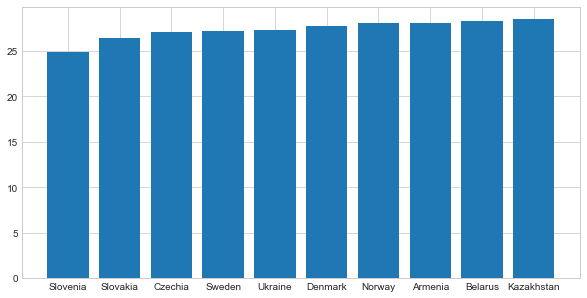

In [41]:
# Visualize the data per year
fig = plt.figure(figsize=(10,5))
x = tmp2['name'].to_list()
y = tmp2['new_gini'].to_list()
plt.bar(x,y)
plt.savefig(Path.cwd()/'Plot'/'M2_Lower_Gini.png')
plt.show()

These results are corroborated by the information find here: https://worldpopulationreview.com/country-rankings/gini-coefficient-by-country

Many European countries have some of the lowest Gini coefficients, such as Slovakia, Slovenia, Sweden, Ukraine, Belgium, and Norway. Inequality is generally lower in European nations than it is in non-European nations. The Nordic countries and Central Eastern European countries are among the most equal countries. 

In [42]:
# Get the 5 countries with the highest Gini index in 2011
tmp.tail(5)

,index,name,year_survey,new_gini,Country Name,year,value,diff
110,17,Central African Republic,2008.0,57.597241,Central African Republic,2008.0,56.2,-1.397241
111,41,Guatemala,2011.0,58.246806,Guatemala,2011.0,NaN,NaN
112,20,Colombia,2008.0,58.343686,Colombia,2008.0,55.5,-2.843686
113,43,Honduras,2008.0,61.551164,Honduras,2008.0,55.5,-6.051164
114,95,South Africa,2008.0,68.294901,South Africa,2008.0,63.0,-5.294901


Still based on the same source, the countries with the highest Gini coefficients are:

    Lesotho (0.632)
    South Africa (0.625)
    Haiti (0.608)
    Botswana (0.605)
    Namibia (0.597)
    Zambia (0.575)
    Comoros (0.559)
    Hong Kong (0.539)
    Guatemala (0.530)
    Paraguay (0.517)

We can see some of them in the top 5 countries from our dataset.    

<b> Overall </b>
- The 5 countries with the highest gini index so the highest inequalities in terms of income are countries located in Central or South America and Africa.
- The 5 countries with the lowest gini index so the lowest inequalities in terms of incomes are countries located in Northern and Eastern Europe.

In [43]:
# Ranking of France
tmp[tmp['Country Name'] == 'France']

,index,name,year_survey,new_gini,Country Name,year,value,diff
38,36,France,2008.0,34.563984,France,2008.0,33.0,-1.563984


France rank at the 38th position in terms of inequalities of income of a total of 115 countries. It is just above the global mean calculated at 39.55. 

In [44]:
# Save dataframe
df2.to_csv(Path.cwd()/'worldbank.csv')
new_gini.to_csv(Path.cwd()/'newgini.csv')